In [9]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys

if "../" not in sys.path:
    sys.path.append("../") 

from collections import defaultdict
from lib.envs.windy_gridworld import WindyGridworldEnv
from lib import plotting
from tqdm import tqdm

matplotlib.style.use('ggplot')

In [10]:
env = WindyGridworldEnv()

In [11]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [23]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1, glie=False):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # for testing GLIE:
    if glie:
        epsilon = 1
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in tqdm(range(num_episodes)):
        
        # initial values:
        state = env.reset()
        action = np.random.choice(np.arange(env.action_space.n), p=policy(state))
        done = False
        
        while not done:
            next_state, reward, done, info = env.step(action)
            next_action = np.random.choice(np.arange(env.action_space.n), p=policy(next_state))
            
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] += 1
            
            td_target = reward + discount_factor * Q[next_state][next_action]
            Q[state][action] += alpha * (td_target - Q[state][action])
            
            state = next_state
            action = next_action
            
            # this line isn't needed as Q is passed by value to the policy function, it automatically
            # takes care of updating the policy, we need it for GLIE
            if glie:
                epsilon = 1 / (i_episode + 1)
                policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    return Q, stats

In [20]:
Q, stats = sarsa(env, 200)

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 195.19it/s]


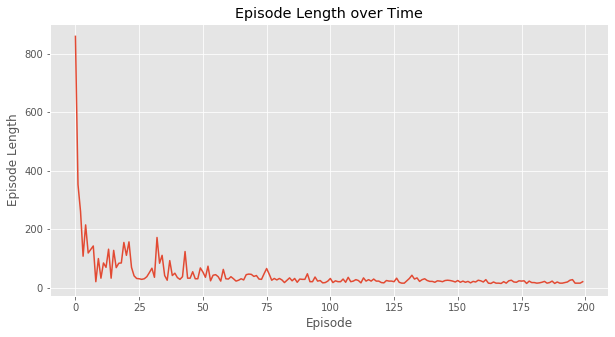

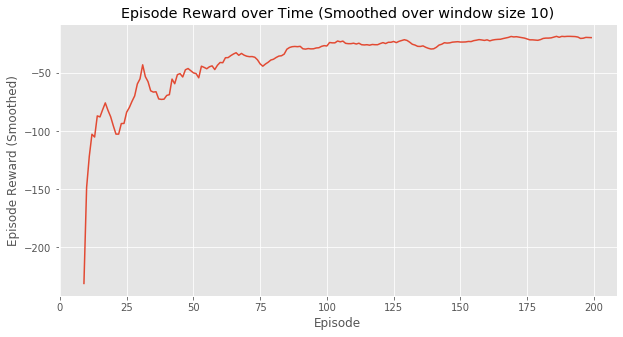

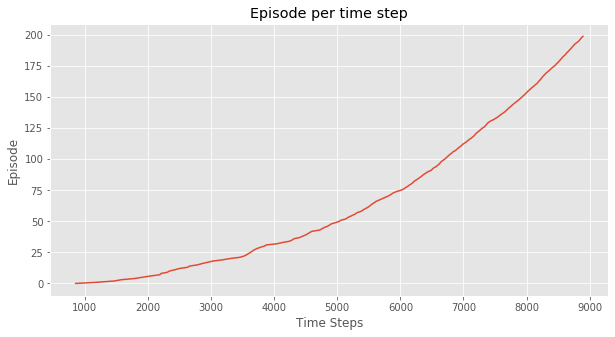

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [14]:
plotting.plot_episode_stats(stats)

In [26]:
# To test out GLIE:
Q, stats = sarsa(env, 200, glie=True)

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 103.66it/s]


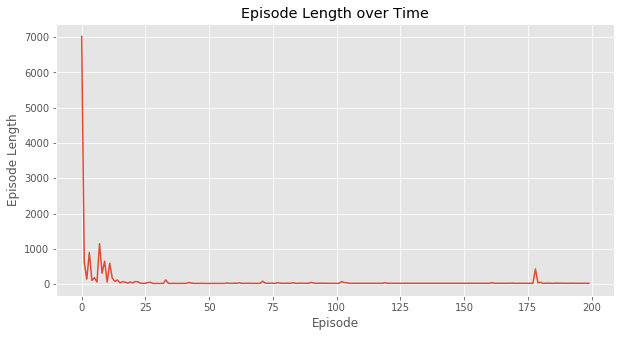

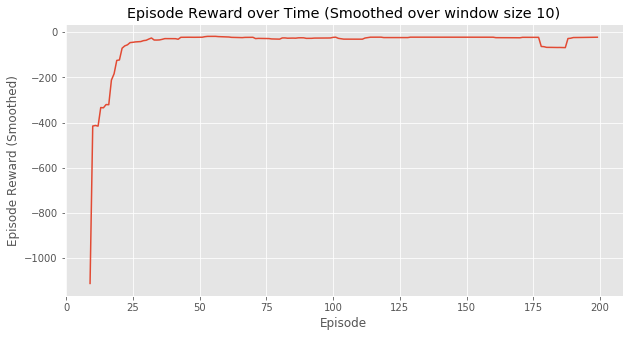

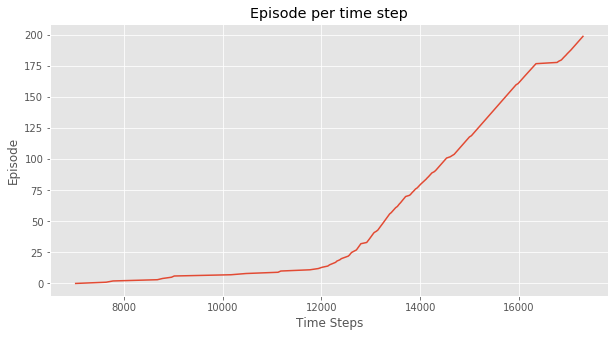

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [27]:
plotting.plot_episode_stats(stats)